# Set Up

In [14]:
# Imports
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Subset
from torch.utils.data import random_split
import matplotlib.pyplot as plt


# Import and Process Data Helper Funtions

In [12]:
# Calculate the mean and standard deviation per-channel
def compute_mean_std(dataset, batch_size=512):
  # Create DataLoader
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

  mean = torch.zeros(3)
  std = torch.zeros(3)
  num_pixels = 0

  # Loop over batches (x = batch of images)
  for x, _ in loader:
    # Unpack dimension: (Batch size, num channels=3, width=32, height=32)
    num_samples_in_batch, _, height, width = x.shape
    # Count number of pixels
    num_pixels += num_samples_in_batch * height * width
    # Sum over each channel (compute the numerators for mean and std)
    mean += x.sum(dim=(0, 2, 3))
    std += (x ** 2).sum(dim=(0, 2, 3))

  # Compute the mean and standard deviations
  mean /= num_pixels
  std = torch.sqrt(std / num_pixels - mean ** 2)

  return mean.tolist(), std.tolist()

# Function to load and split the dataset
def load_and_split_cifar10(data_root="./data", val_split=0.16, seed=42):

  base_transform = transforms.ToTensor()

  # Load the training dataset (without normalization)
  train_full_original = datasets.CIFAR10(root=data_root, train=True, download=True, transform=base_transform)

  # Calculate the mean and standard deviation on the training set
  mean, std = compute_mean_std(train_full_original)

  # Construct the transform with normalization
  final_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

  # Load datasets with normalization
  train_full = datasets.CIFAR10(root=data_root,train=True, download=False, transform=final_transform)
  test_set = datasets.CIFAR10(root=data_root, train=False,download=True,transform=final_transform)

  # Create validation set from the training dataset
  val_size = int(len(train_full) * val_split)
  train_size = len(train_full) - val_size
  g = torch.Generator().manual_seed(seed)
  train_set, val_set = random_split(train_full, [train_size, val_size], generator=g)

  return train_set, val_set, test_set, mean, std


In [23]:
# Function to process the data and generate the data loaders
def process_data(batch_size=128, val_split=0.16,poison=False, plot_distribution=True):
  # Load dataset and create splits
  train_set, val_set, test_set, mean, std = load_and_split_cifar10(val_split=val_split)

  if plot_distribution:
    plot_class_distribution(train_set, "Training set")
    plot_class_distribution(val_set, "Validation set")
    plot_class_distribution(test_set, "Test set")

  if poison:
      print("CALL FUNCTION TO POISON THE DATA")
      if plot_distribution:
        plot_class_distribution(train_set, "Training set - Poisoned")
        plot_class_distribution(val_set, "Validation set - Poisoned")
        plot_class_distribution(test_set, "Test set -  Poisoned")


  # Create DataLoaders from datasets
  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False)
  test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

  print(f"Computed normalization stats:")
  print(f"Mean: {mean}")
  print(f"Std:  {std}")

  return train_loader, val_loader, test_loader

# Graphing Helper Functions

In [22]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Subset

CIFAR10_CLASSES = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

def plot_class_distribution(dataset, title):
    # Get labels
    if isinstance(dataset, Subset):
        labels = [dataset.dataset.targets[i] for i in dataset.indices]
    else:
        labels = dataset.targets

    # Get counts per category
    counts = torch.bincount(torch.tensor(labels), minlength=len(CIFAR10_CLASSES))

    plt.figure(figsize=(10, 4))
    plt.bar(CIFAR10_CLASSES, counts)
    plt.ylabel("Number of samples")
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


# Main Workflow

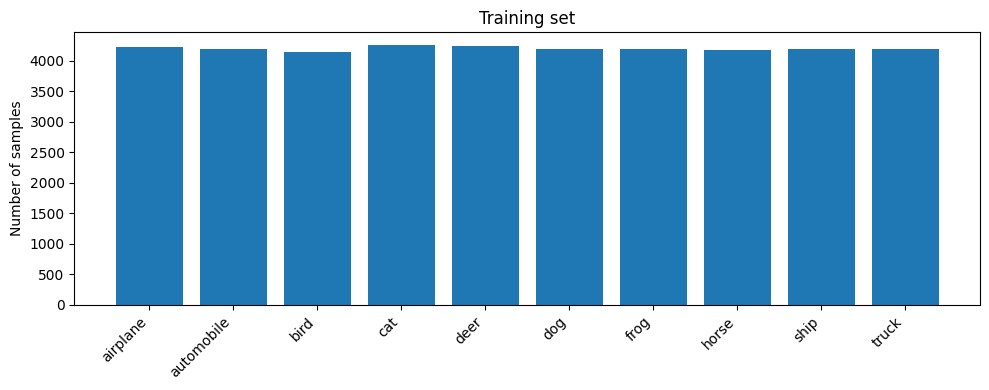

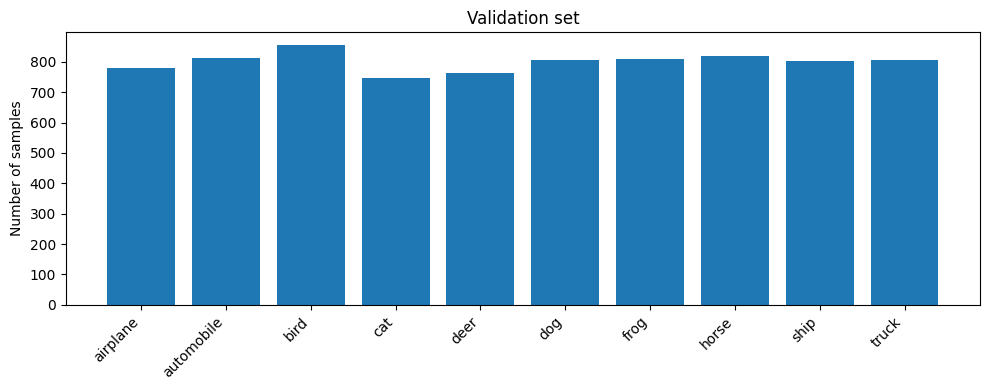

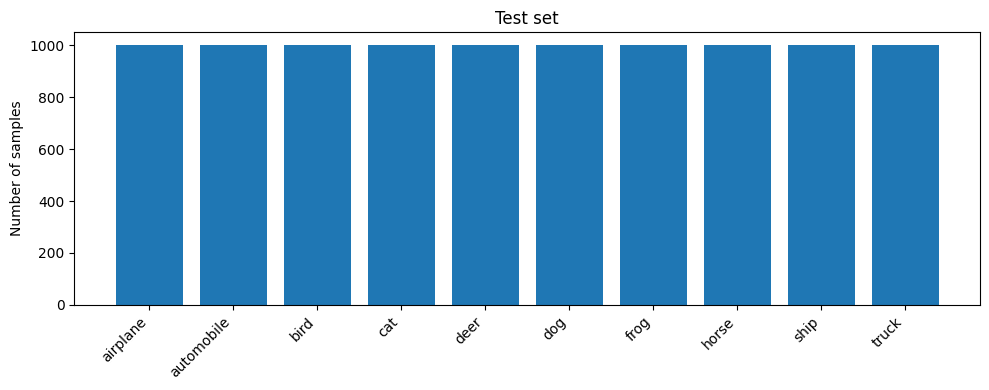

Computed normalization stats:
Mean: [0.4913996756076813, 0.48215851187705994, 0.4465310275554657]
Std:  [0.24703219532966614, 0.24348489940166473, 0.2615877091884613]


In [24]:
# Get dataloader for each dataset
train_loader, val_loader, test_loader = process_data()